In [1]:
import os
import pickle

path = '/kaggle/input/preprocessed-multiband/'
with open(os.path.join(path, "preprocessed_multiband_eeg.pkl"), "rb") as f:
    processed = pickle.load(f)

In [2]:
X_preprocessed = processed['X']
y_preprocessed = processed['y']

print(X_preprocessed['delta'].shape)
print(y_preprocessed.shape)

(34230, 32, 125)
(34230,)


In [3]:
from keras.utils import to_categorical
import numpy as np

X_preprocessed = np.stack([
    X_preprocessed['delta'],
    X_preprocessed['theta'],
    X_preprocessed['alpha'],
    X_preprocessed['beta']
], axis=1)

X_transposed_pre = np.transpose(X_preprocessed, (0, 1, 3, 2))
y_cat_pre = to_categorical(y_preprocessed, num_classes=10)

print(X_transposed_pre.shape)
print(y_cat_pre.shape)

2025-07-22 03:47:03.719527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753156024.097260      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753156024.202372      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(34230, 4, 125, 32)
(34230, 10)


In [4]:
import pandas as pd
import numpy as np
import os

path = "/kaggle/input/raw-eeg-2b"
X_batch = pd.read_csv(os.path.join(path, "X_raw_train2B.csv"), header=0)
y_batch = pd.read_csv(os.path.join(path, "y_raw_train2B.csv"), header=0)

X_batch = X_batch.to_numpy()
labels = y_batch.to_numpy().flatten()

n_channels = 32
n_timesteps = 256
X = X_batch.reshape(-1, n_channels, n_timesteps)

print(X.shape)
print(labels.shape)

(30000, 32, 256)
(30000,)


In [5]:
path = '/kaggle/input/preprocessed-multiband/'
used_indices = np.load(os.path.join(path, "used_indices.npy"))

global_raw = []
for item in used_indices:
    signal_construct = np.mean(X[item], axis=0, keepdims=True)
    global_raw.append(signal_construct)

duplicated = []
for src in processed['duplication_sources']:
    if (isinstance(src, tuple)):
        (src1, src2), lam = src
        if (lam < 0.5):
            duplicated.append(global_raw[src2])
        else:
            duplicated.append(global_raw[src1])
    else:
        duplicated.append(global_raw[src])
print(len(duplicated))

raw_duplicated = np.concatenate([global_raw, duplicated], axis=0)
print(raw_duplicated.shape)

4230
(34230, 1, 32, 256)


In [6]:
import os
import numpy as np

path = "/kaggle/input/mnist-images/"
images = np.load(os.path.join(path, "MNIST_images.npy"))

In [7]:
import os
import numpy as np

path = '/kaggle/input/preprocessed-multiband/'
used_indices = np.load(os.path.join(path, 'used_indices.npy'))

In [8]:
global_images = []

for i in range(len(used_indices)):
    group_image = images[used_indices[i]]
    
    # Calculate mean of images from the group
    mean_img = np.mean(group_image, axis=0)

    # Take the most representative one (according to MSE)
    MSE_list = [np.mean((img - mean_img)**2) for img in group_image]
    representative_image = images[used_indices[i][np.argmin(MSE_list)]]
    global_images.append(representative_image)

global_images = np.array(global_images)
print(global_images.shape)

(30000, 28, 28)


In [9]:
padded = np.pad(np.array(global_images), ((0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)
print(padded.shape)

(30000, 32, 32)


In [10]:
duplicated = []
for src in processed['duplication_sources']:
    if (isinstance(src, tuple)):
        (src1, src2), lam = src
        if (lam < 0.5):
            duplicated.append(padded[src2])
        else:
            duplicated.append(padded[src1])
    else:
        duplicated.append(padded[src])

print(len(duplicated))

4230


In [11]:
combined = np.concatenate([padded, duplicated], axis=0)
print(combined.shape)

(34230, 32, 32)


In [12]:
# BEST CLASSIFICATION FOR PREPROCESSED DATA
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final-multiband/keras/default/1"
best_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_LSTM_final_multiband.keras'))

I0000 00:00:1753156159.846208      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753156159.846879      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
from tensorflow.keras.models import Model

def make_pairs(model, X, y, imgs, raw):
    encoder_model = Model(inputs=model.input, outputs=model.get_layer('latent_vector').output)
    encoder_model.compile()
    latent_vectors = encoder_model.predict(X)
    
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y, axis=1)
    true_indices = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i]]

    final_true_pairs = [(latent_vectors[i],
                         X[i],
                         y[i],        
                         imgs[i], 
                         raw[i])
                         for i in true_indices]
    
    final_false_pairs = [(latent_vectors[i],
                          X[i],
                          y_pred_probs[i],        
                          imgs[i], 
                          raw[i])
                         for i in range(len(y_pred)) 
                         if i not in true_indices]

    return final_true_pairs, final_false_pairs

In [14]:
from sklearn.model_selection import train_test_split

X_train_pre, X_val_pre,     \
y_train_pre, y_val_pre,     \
img_train_pre, img_val_pre, \
X_train_raw, X_val_raw      \
    = train_test_split (
        X_transposed_pre, 
        y_cat_pre,
        combined,
        raw_duplicated,
        
    
        test_size    = 0.2,
        random_state = 42, 
        shuffle      = True, 
        stratify     = y_cat_pre
    )

In [15]:
final_pre_pairs, final_false_pairs = make_pairs(best_model, X_val_pre, y_val_pre, img_val_pre, X_val_raw)

I0000 00:00:1753156174.491316      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


214/214 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step


In [16]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [17]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

In [18]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

In [19]:
import torch
import os

# Path ke model
generator_path = "/kaggle/input/reimage-generation-models/tensorflow2/default/1/MNIST_cDCGAN_generator_param.pkl"
discriminator_path = "/kaggle/input/reimage-generation-models/tensorflow2/default/1/MNIST_cDCGAN_discriminator_param.pkl"

# Load model
G = generator(128)
D = discriminator(128)

# Load parameter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G.load_state_dict(torch.load(generator_path, map_location=device))
D.load_state_dict(torch.load(discriminator_path, map_location=device))

G.eval()
D.eval()

print("Models loaded successfully!")

Models loaded successfully!


In [20]:
import torch

all_z = torch.cat([torch.tensor(z) for z, _, _, _, _ in final_pre_pairs], dim=0)
all_y = torch.cat([torch.tensor(y) for _, _, y, _, _ in final_pre_pairs], dim=0)
    
# real_imgs = torch.cat([torch.tensor(img).unsqueeze(0) for _, _, img in final_pre_pairs])
# real_imgs = (real_imgs.float() / 255.0 - 0.5) / 0.5

fixed_z_ = all_z.view(-1, 100, 1, 1).float().cuda()
fixed_y_label_ = all_y.view(-1, 10, 1, 1).float().cuda()
# real_imgs = real_imgs.unsqueeze(1).cuda()

In [21]:
import torch

all_z = torch.cat([torch.tensor(z) for z, _, _, _, _ in final_false_pairs], dim=0)
all_y = torch.cat([torch.tensor(y) for _, _, y, _, _ in final_false_pairs], dim=0)
    
# real_imgs = torch.cat([torch.tensor(img).unsqueeze(0) for _, _, img in final_pre_pairs])
# real_imgs = (real_imgs.float() / 255.0 - 0.5) / 0.5

fixed_false_z_ = all_z.view(-1, 100, 1, 1).float().cuda()
fixed_false_y_label_ = all_y.view(-1, 10, 1, 1).float().cuda()
# real_imgs = real_imgs.unsqueeze(1).cuda()

In [22]:
# SSIM
from skimage.metrics import structural_similarity as ssim

def SSIM(generated, original):
    score = ssim(generated, original, data_range=original.max() - original.min())
    return score

In [23]:
# PSNR
# Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [24]:
from torchmetrics.multimodal.clip_score import CLIPScore
import torch
import numpy as np
from PIL import Image

metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")
number_text = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

def CLIP_score(image, label_onehot):
    try:
        if isinstance(label_onehot, torch.Tensor):
            label_onehot = label_onehot.detach().cpu().numpy()

        label = int(np.argmax(label_onehot, axis=1).squeeze())

        if isinstance(image, np.ndarray):
            image_tensor = torch.tensor(image).float()
        else:
            image_tensor = image.float()

        image_tensor = torch.clamp(image_tensor, 0.0, 1.0)

        if image_tensor.ndim == 4:
            image_tensor = image_tensor.squeeze(0)
        if image_tensor.ndim == 2:
            image_tensor = image_tensor.unsqueeze(0)
        if image_tensor.shape[0] != 3:
            image_tensor = image_tensor.repeat(3, 1, 1)
        if image_tensor.shape[1] != 224 or image_tensor.shape[2] != 224:
            image_tensor = torch.nn.functional.interpolate(
                image_tensor.unsqueeze(0), size=(224, 224), mode='bilinear'
            ).squeeze(0)

        image_tensor = image_tensor.unsqueeze(0).to(metric.device)

        prompt = f"white handwritten digit {number_text[label]} with black background"
        return metric(image_tensor, [prompt]).item()

    except Exception as e:
        print("CLIP_score error:", e)
        return None

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [25]:
def RMSE(fake_image, target_image):
    rmse_score = np.sqrt(np.mean((fake_image - target_image) ** 2)) 
    return rmse_score

In [26]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def inference(test):
    global G

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.eval()
    G = G.to(device)

    # --- Ambil komponen ---
    final_pre_pairs = test[0]
    z = test[1].unsqueeze(0)         # (100,) → (1, 100)
    y_label = test[2].unsqueeze(0)   # (10,) → (1, 10)

    latent_vector = final_pre_pairs[0]
    preprocessed_signal_np = final_pre_pairs[1]  
    preprocessed_signal_np = np.expand_dims(preprocessed_signal_np, axis=0)

    label_np = final_pre_pairs[2]                   
    original_image = final_pre_pairs[3]             
    raw_signal = final_pre_pairs[4]        

    # --- Generate image ---
    with torch.no_grad():
        generated_image = G(z, y_label).squeeze().cpu()

    # --- Klasifikasi sinyal preprocessed ---
    pred = best_model.predict(preprocessed_signal_np)
    pred_label = np.argmax(pred, axis=1).item()

    # --- True label (jika one-hot) ---
    if isinstance(label_np, (list, np.ndarray)) and len(label_np) > 1:
        true_label = int(np.argmax(label_np))
    else:
        true_label = int(label_np)

    # --- Visualisasi ---
    fig, axs = plt.subplots (
        2, 3, figsize=(15, 8),
        gridspec_kw={'width_ratios': [2, 0.5, 1]}
    )

    axs[0,0].plot(raw_signal[0][16])
    axs[0,0].set_title("Raw Signal")

    bands = ['Delta', 'Theta', 'Alpha', 'Beta']
    for i in range(4):
        axs[1,0].plot(preprocessed_signal_np[0, i, :, 16], label=bands[i])
    axs[1,0].set_title("Preprocessed Signal")
    axs[1,0].legend(loc='upper right')

    axs[0,2].imshow(original_image, cmap='gray')
    axs[0,2].set_title(f"Original Image (label={true_label})")

    axs[1,2].imshow(generated_image.numpy(), cmap='gray')
    axs[1,2].set_title("Generated Image")

    axs[0,1].axis('off')
    axs[0,1].text(0, 0.8, f"True Label: {true_label}", fontsize=12)
    axs[0,1].text(0, 0.6, f"Predicted Label: {pred_label}", fontsize=12)

    # --- Metrik ---
    img_real = original_image.squeeze()
    img_gen = generated_image.numpy()

    ssim_val = SSIM(img_gen, img_real)
    psnr_val = PSNR(img_real, img_gen)
    clip_val = CLIP_score(img_real, y_label)
    rmse_val = RMSE(img_gen, img_real)

    axs[1,1].axis('off')
    axs[1,1].text(0, 0.9, f'SSIM: {ssim_val:.4f}', fontsize=10)
    axs[1,1].text(0, 0.7, f'PSNR: {psnr_val:.4f} dB', fontsize=10)
    axs[1,1].text(0, 0.5, f'CLIP: {clip_val:.4f}', fontsize=10)
    axs[1,1].text(0, 0.3, f'RMSE: {rmse_val:.4f}', fontsize=10)

    # plt.tight_layout()
    plt.show()

In [27]:
# 900, 550, 150, 700

In [37]:
i =550

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


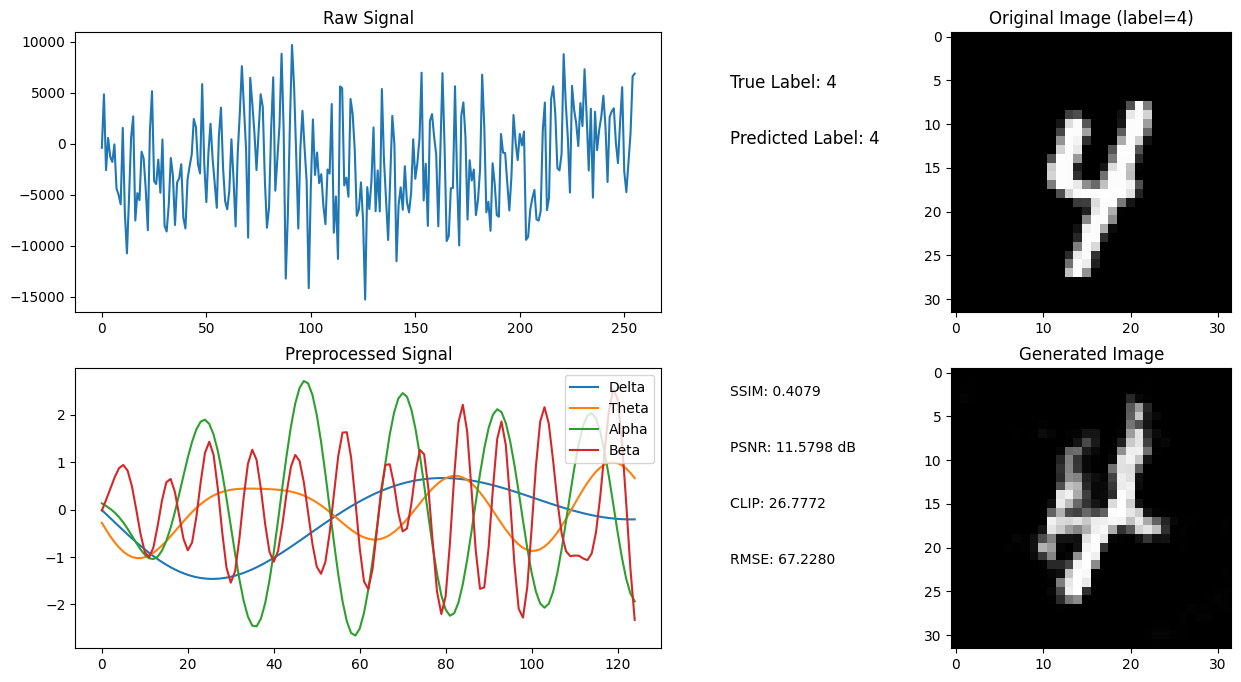

In [38]:
# format: final_pre_pairs, latent (torch), label (torch)
test = [final_pre_pairs[i], fixed_z_[i], fixed_y_label_[i]]
inference(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


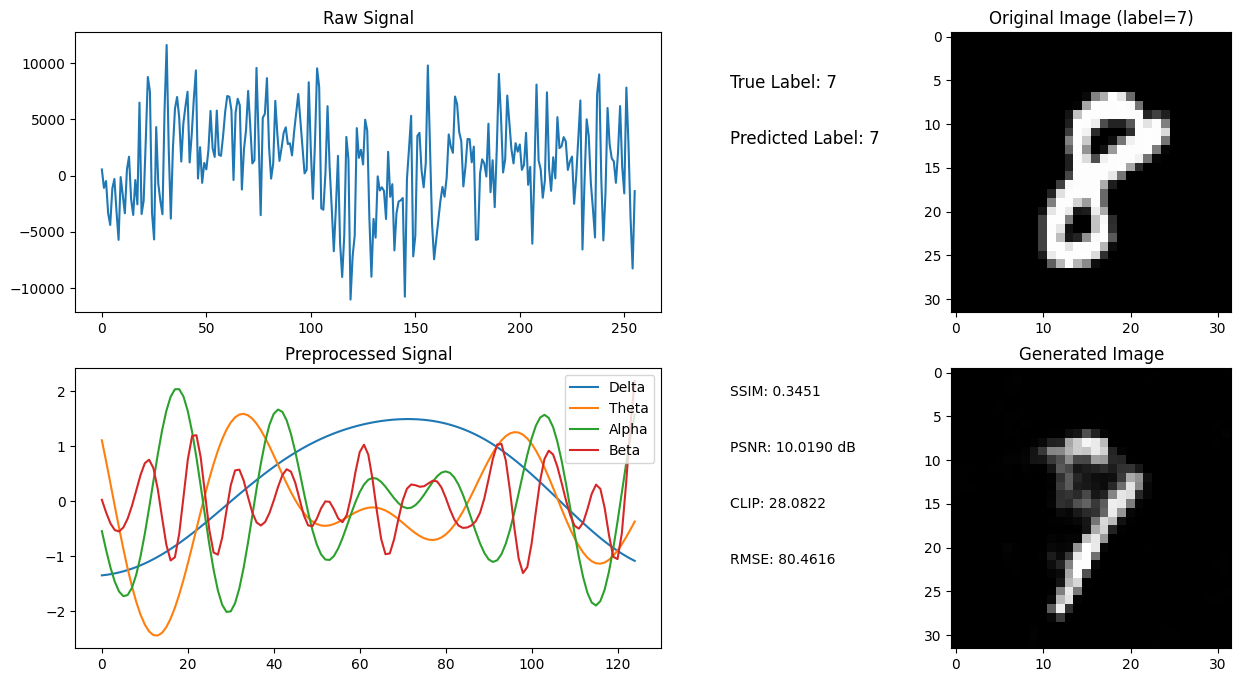

In [39]:
# format: final_false_pairs, latent (torch), label (torch)
test = [final_false_pairs[i], fixed_false_z_[i], fixed_false_y_label_[i]]
inference(test)